In [1]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.spatial.distance as spsd

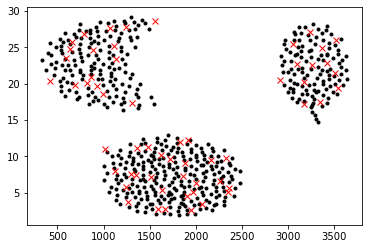

In [2]:
data = np.loadtxt('cluster.dat')

testing = np.array([ item for index, item in enumerate(data) if index % 10 == 0 ])
training = np.array([ item for index, item in enumerate(data) if index % 10 >= 1 ])

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(testing[:,0], testing[:,1], 'x', color='red')
plot.show()

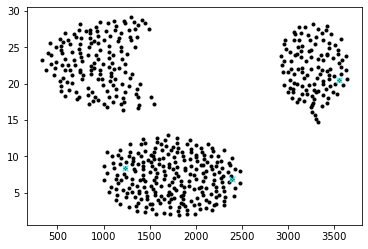

In [3]:
def pick_cluster_centers(array, k):
    centers = []
    for i in range(k):
        p_dist = np.ones(array.shape[0])
        for j in range(array.shape[0]):
            if centers:
                distances = spsd.cdist(np.array([array[j]]), centers)
                p_dist[j] = min(distances)[0]
        p_dist /= sum(p_dist)
        ai = np.random.choice(array.shape[0], p = p_dist)
        centers.append(array[ai])
    return np.array(centers)

centers = pick_cluster_centers(training, 3)

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(centers[:,0], centers[:,1], 'x', color='cyan')
plot.show()

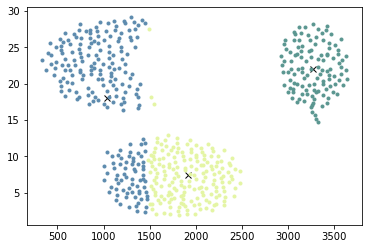

In [4]:
def get_cluster_data(array, centers):
    distances = spsd.cdist(array, centers)
    clusterization = np.argmin(distances, axis=1)
    clusters = {}
    for i in range(centers.shape[0]):
        indices = np.where(clusterization == i)
        clusters[i] = np.take(array, indices, 0)
    return clusters

def kmeans(array, k, diff=0.1):
    centers = pick_cluster_centers(array, k)

    changed = True
    while (changed):
        clusters = get_cluster_data(array, centers)
        
        new_centers = np.empty(centers.shape)
        for i in range(k):
            new_centers[i] = np.mean(clusters[i], 1)
        
        if abs(np.sum(new_centers - centers)) > diff:
            centers = new_centers
        else:
            changed = False
    return centers

cluster_centers = kmeans(training, 3)
clusters = get_cluster_data(training, cluster_centers)
plot.plot(cluster_centers[:,0], cluster_centers[:,1], 'x', color='black')
for i in clusters:
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.show()